<a href="https://colab.research.google.com/github/joherra/MyApplication/blob/master/Proyecto%202.A.%20Caso%20Pr%C3%A1ctico.%20DSS%20para%20la%20ETAP%20de%20Logro%C3%B1o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- *Asignatura*: Ingeniería del Conocimiento
- *Curso*: 2020/2021
- *Profesor*: Fco. Javier Martínez de Pisón
- Universidad de La Rioja

# Caso Práctico Final: DSS para la ETAP de Logroño

La *Estación de Tratamiento de Agua Potable de Logroño (TAP Río Iregua)* abastece a una población cercana a los 200.000 habitantes, entre los municipios de Logroño, Alberite, Villamediana y Lardero, además de varios polígonos industriales. Las instalaciones de Lardero, donde se realiza el tratamiento principal, se encuentran atendidas en todo momento, es decir, 24 horas los 365 días del año. En más del cincuenta por ciento del tiempo solamente hay una persona que controla las instalaciones, aunque con los conocimientos suficientes para manejar todos los elementos convencionales que afectan al funcionamiento del proceso.

![](https://www.larioja.org/consorcio-aguas/es/abastecimientos-supramunicipales/bajo-iregua/t-p-bajo-iregua.ficheros/881945-ETAP%20Bajo%20Iregua.jpg)

Existen ocasiones en las que **las condiciones del agua captada en el río cambian de manera muy brusca**. Es el caso de bruscas variaciones en el parámetro de turbidez debidas a tormentas, deshielos o movimientos de tierras cercanos a la captación; o de calidad del agua debido a vertidos incontrolados.

Habitualmente, en estos casos se realizan cambios en las dosis de floculante, cloro, u otros tratamientos que permiten controlar la calidad del agua potable; sin embargo, cuando las condiciones son extremas o la incertidumbre es grande, podría ser útil realizar acciones más drásticas como, por ejemplo:

1.	Detener la entrada de agua a la ETAP durante un número de horas determinado.
2.	Disminuir el caudal de entrada para minimizar el gasto en tratamientos.
3.	Otras posibles acciones de mantenimiento o reparación.

El alcance de este proyecto **comprende el desarrollo de un sistema de apoyo a la toma de decisiones (DSS) en la ETAP Río Iregua que permita predecir el consumo en horas posteriores que ayuden a asegurar que las paradas o disminución de caudal no supongan graves contratiempos en el suministro final de agua**. En definitiva, los objetivos de este proyecto son el desarrollo de modelos predictivos que puedan ser integrados en un sistema inteligente de apoyo a la toma de decisiones en la gestión de aguas de la ETAP de Logroño.

En este proyecto se trabajará con el archivo *'etap_entrenam2008_2009.arff'* para el entrenamiento de los modelos y *'etap_testeo2010.arff'* para testear los modelos finales. Finalmente, se guardará el mejor modelo para poder predecir el consumo probable de cada hora según las condiciones previstas en las horas posteriores.


In [1]:
# Importamos paquetes basicos
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

### Leemos la Base de Datos y Preprocesamos

In [2]:
!wget https://github.com/IC1920/Datasets/raw/master/etap_entrenam2008_2009.arff -O etap_entrenam2008_2009.arff
!wget https://github.com/IC1920/Datasets/raw/master/etap_testeo2010.arff -O etap_testeo2010.arff

--2021-05-06 21:04:54--  https://github.com/IC1920/Datasets/raw/master/etap_entrenam2008_2009.arff
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IC1920/Datasets/master/etap_entrenam2008_2009.arff [following]
--2021-05-06 21:04:54--  https://raw.githubusercontent.com/IC1920/Datasets/master/etap_entrenam2008_2009.arff
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 912923 (892K) [text/plain]
Saving to: ‘etap_entrenam2008_2009.arff’

etap_entrenam2008_2 100%[===================>] 891.53K  --.-KB/s    in 0.01s   

2021-05-06 21:04:55 (69.0 MB/s) - ‘etap_entrenam2008_2009.arff’ saved [912923/912923

In [3]:
# Leemos los archivos arff
df_train = pd.DataFrame(arff.loadarff("etap_entrenam2008_2009.arff")[0])
df_test = pd.DataFrame(arff.loadarff("etap_testeo2010.arff")[0])

# Eliminamos la b y las comillas de las categóricas
for colname in ['fecha', 'nom_mes', 'festivo', 'nom_diasem']:
    df_train[colname] = df_train[colname].astype(str).str.replace('b','').str.replace("'","")
    df_test[colname] = df_test[colname].astype(str).str.replace('b','').str.replace("'","")

display(df_train.head(3), df_test.head(3))

,fecha,anio,mes,nom_mes,diames,festivo,diasem,nom_diasem,hora,temp,consumo
0,1/1/2008,2008.0,1.0,ene,1.0,TRUE,2.0,mar,1.0,-0.275,771.320
1,1/1/2008,2008.0,1.0,ene,1.0,TRUE,2.0,mar,2.0,-0.750,999.210
2,1/1/2008,2008.0,1.0,ene,1.0,TRUE,2.0,mar,3.0,-1.650,1376.105


,fecha,anio,mes,nom_mes,diames,festivo,diasem,nom_diasem,hora,temp,consumo
0,4/1/2010,2010.0,1.0,ene,4.0,FALSE,1.0,lun,16.0,5.200,1709.175
1,4/1/2010,2010.0,1.0,ene,4.0,FALSE,1.0,lun,17.0,5.275,1507.580
2,4/1/2010,2010.0,1.0,ene,4.0,FALSE,1.0,lun,18.0,5.650,1358.575


Las variables de la base de datos son las siguientes:

1.	Fecha (*fecha*): fecha del registro. Formato Fecha.
2.	Año (*anio*): variable numérica.
3.	Mes (*mes*): variable numérica.
4.	Nombre del mes (*nom_mes*): nombre del mes. Variable categórica.
5.	Día del mes (*diames*): día del mes. Variable numérica.
6.	Día festivo o no (*festivo*): si es un día festivo o no. Variable booleana.
7.	Día de la semana (*diasem*): día de la semana en formato numérico.
8.	Nombre del día de la semana  (*nom_diasem*): nombre del día de la semana. Variable categórica.
9.	Hora (*hora*): franja horaria de suministro (de 0 a 23).
10.	Temperatura ambiental (*temp*): temperatura ambiental en (ºC). Variable numérica.

Y como variable de salida:

11.	Consumo final (*consumo*): consumo de agua en metros cúbicos por hora. Variable numérica a predecir.

Los datos de consumo han sido modificados con el objetivo de preservar la confidencialidad de los mismos.


#  1. Ejercicio Propuesto

A partir del archivo *“etap_entrenam2008_2009.arff”*:

1. Según lo visto en proyectos anteriores, desarrollar modelos de regresión los más precisos posibles del consumo de agua. Para ello, seleccione las variables más importantes que influyen en el modelo. Se recomienda utilizar el año 2008 para entrenamiento y el 2009 para validación simple. Explicar el proceso para obtener el mejor modelo con cada técnica, parámetros ajustados, rango de los mismos, errores obtenidos. Identificar qué técnicas han obtenido mejores modelos, qué variables han sido seleccionadas para cada uno y los parámetros finales del algoritmo. Presentar en una tabla los resultados de los modelos con mejores errores (RMSE y MAE) obtenidos con cada técnica.
2. Extraiga los resultados de predicción con la base de datos *“etap_testeo2010.arff”* de los modelos que han obtenido el menor RMSE de testeo con cada técnica, páselos a EXCEL y presente en unas gráficas los valores reales frente a los valores predichos de los mejores modelos con las tres mejores técnicas. Saque gráficas por meses o semanas, en diferentes épocas del año, para poder ver mejor la diferencia entre los resultados.
3. Presente una tabla con los errores de validación frente a los de testeo para cada técnica. Compare los errores obtenidos con la base de datos de testeo del año 2010 con los errores de validación del 2009. ¿Son similares? ¿Existen diferencias significativas en algún método?
4. Analice los datos extremos (con residuos más elevados) y saque conclusiones sobre la fiabilidad de cada uno de los modelos. Muestre los valores de las entradas que producen esos datos extremos y explique una posible causa que los produzcan.

In [4]:
print(df_train.shape, df_test.shape)

(16783, 11) (8120, 11)


In [5]:
consumo = df_train["consumo"]
print(consumo.sort_values(ascending=False))

6162     4005.6050
13136    3935.4850
14725    3751.4200
16418    3707.5950
3697     3365.7600
           ...    
8611      149.0050
9314      149.0050
8566      127.0925
8631      113.9450
8634       96.4150
Name: consumo, Length: 16783, dtype: float64


In [6]:
df_train = df_train.loc[df_train["consumo"] < 3700]

#https://www.geeksforgeeks.org/python-pandas-dataframe-reset_index/#:~:text=Pandas%20reset_index()%20is%20a,length%20of%20data%20as%20index.&text=Parameters%3A,remove%20passed%20column%20from%20index.
#Para resetear los indices y tengan un orden
df_validacion = df_train.loc[df_train["anio"] == 2009].reset_index(drop=True)
df_train = df_train.loc[df_train["anio"] == 2008].reset_index(drop=True)

#Pasamos festivo a numerico
df_train["festivoNumerico"] = (df_train["festivo"] == "TRUE").astype(int)
df_validacion["festivoNumerico"] = (df_validacion["festivo"] == "TRUE").astype(int)
df_test["festivoNumerico"] = (df_test["festivo"] == "TRUE").astype(int)

#No puedo usar fecha por que da el problema de could not convert string to float: '1/1/2008' cuando se intenten hacer modelos
df_train = df_train[["mes","diames","festivoNumerico","hora","temp","consumo"]]
#df_validacion = df_validacion[["mes","diames","festivoNumerico","hora","temp","consumo"]]
df_test = df_test[["mes","diames","festivoNumerico","hora","temp","consumo"]]


In [7]:
print(df_test["festivoNumerico"] == 1)
display(df_train.head(20), df_test.head(20))

0       False
1       False
2       False
3       False
4       False
        ...  
8115    False
8116    False
8117    False
8118    False
8119    False
Name: festivoNumerico, Length: 8120, dtype: bool


,mes,diames,festivoNumerico,hora,temp,consumo
0,1.0,1.0,1,1.0,-0.275,771.320
1,1.0,1.0,1,2.0,-0.750,999.210
2,1.0,1.0,1,3.0,-1.650,1376.105
3,1.0,1.0,1,4.0,-2.100,1726.705
4,1.0,1.0,1,5.0,-2.550,1919.535
5,1.0,1.0,1,6.0,-2.600,1858.180
6,1.0,1.0,1,7.0,-2.925,1516.345
7,1.0,1.0,1,8.0,-2.250,1297.220
8,1.0,1.0,1,9.0,-1.150,1419.930
9,1.0,1.0,1,10.0,0.475,1367.340


,mes,diames,festivoNumerico,hora,temp,consumo
0,1.0,4.0,0,16.0,5.200,1709.175
1,1.0,4.0,0,17.0,5.275,1507.580
2,1.0,4.0,0,18.0,5.650,1358.575
3,1.0,4.0,0,19.0,5.875,1297.220
4,1.0,4.0,0,20.0,6.000,1209.570
5,1.0,4.0,0,21.0,6.175,1411.165
6,1.0,4.0,0,22.0,6.225,1481.285
7,1.0,4.0,0,23.0,6.225,1341.045
8,1.0,5.0,0,0.0,6.150,1165.745
9,1.0,5.0,0,1.0,6.275,946.620


In [8]:
from sklearn.preprocessing import StandardScaler
# Variables seleccionadas para la creación del modelo THC1
selec_features = ["mes","diames","festivoNumerico","hora","temp"]
target = ["consumo"]

# Estandarizamos las bases de datos de entrenamiento y testeo
scaler = StandardScaler()
scaler.fit(df_train[selec_features].values)
df_train_esc = scaler.transform(df_train[selec_features].values)
df_test_esc = scaler.transform(df_test[selec_features].values)
df_validacion_esc = scaler.transform(df_validacion[selec_features].values)
print(df_train_esc.shape)

(8538, 5)


In [9]:
def entrena_model(model):

    X_test = df_test_esc.copy()
    y_test = df_test[["consumo"]].values.reshape(-1)

    X_train = df_train_esc.copy()
    y_train = df_train[["consumo"]].values.reshape(-1)

    X_validacion = df_validacion_esc.copy()
    y_validacion = df_validacion[["consumo"]].values.reshape(-1)
     
    model.fit(X_train, y_train)
    prediccion_validacion = model.predict(X_validacion)
    prediccion_testeo = model.predict(X_test)
    prediccion_train = model.predict(X_train)
    
    # Extrae las métricas
    #Extraemos el mae de validación
    mae_val = mean_absolute_error(y_validacion, prediccion_validacion)
    #Extraemos el rmse de validación
    rmse_val = np.sqrt(mean_squared_error(y_validacion, prediccion_validacion))
    #Extraemos el R2 de validación
    r2_val = r2_score(y_validacion, prediccion_validacion)
    #Extraemos el mae de testeo
    mae_tst = mean_absolute_error(y_test, prediccion_testeo)
    #Extraemos el rmse de testeo
    rmse_tst = np.sqrt(mean_squared_error(y_test, prediccion_testeo))
    #Extraemos el R2 de testeo
    r2_tst = r2_score(y_test, prediccion_testeo)

    #Devolvemos lo valores
    return mae_val, rmse_val, r2_val, mae_tst, rmse_tst, r2_tst, y_validacion, prediccion_validacion, y_test, prediccion_testeo, y_train, prediccion_train

In [10]:
def dibuja_preds(y_true, y_pred, mae, rmse, r2tst, titulo='Real vs Prediccion'):
    titulo = titulo+'MAE:{:.3f}, RMSE:{:,.3f}, R2:{:,.3f}'.format(mae, rmse, r2tst)
    plt.figure(figsize=(8,8))
    # Diagonal
    min_x, max_x = y_true.min(), y_true.max()
    min_y, max_y = y_pred.min(), y_pred.max()
    # Preds vs Real
    min_tot = min(min_x,min_y)
    max_tot = max(max_x,max_y)
    plt.scatter(y_true,y_pred,alpha=0.80)
    plt.plot([min_tot, max_tot],[min_tot, max_tot], color='red')
    plt.xlabel('Real')
    plt.ylabel('Predicción')
    plt.title(titulo)
    plt.show()

Uso de modelo el de la 2.2 pero me cargo todo lo de la validación cruzada

In [11]:
#Modelo Ridge Linear Regresion
from sklearn.linear_model import Ridge
# Probamos con diferentes potencias de 10
for alpha in np.power(10.0,np.arange(-2,5,0.3)):
    model = Ridge(alpha=alpha)
    mae_val, rmse_val, r2_val, mae_tst, rmse_tst, r2_tst, _, _, _, _ = entrena_model(model)
    print('RIDGE con alpha={:.1e} ->\
    Val:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}] \
    Test:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}]'.format(alpha, 
                                                      mae_val, rmse_val, r2_val, 
                                                      mae_tst, rmse_tst, r2_tst))

RIDGE con alpha=1.0e-02 ->    Val:[MAE=275.590,RMSE=337.032,R2=0.319]     Test:[MAE=285.902,RMSE=347.252,R2=0.316]
RIDGE con alpha=2.0e-02 ->    Val:[MAE=275.590,RMSE=337.032,R2=0.319]     Test:[MAE=285.902,RMSE=347.252,R2=0.316]
RIDGE con alpha=4.0e-02 ->    Val:[MAE=275.590,RMSE=337.032,R2=0.319]     Test:[MAE=285.902,RMSE=347.252,R2=0.316]
RIDGE con alpha=7.9e-02 ->    Val:[MAE=275.590,RMSE=337.032,R2=0.319]     Test:[MAE=285.902,RMSE=347.252,R2=0.316]
RIDGE con alpha=1.6e-01 ->    Val:[MAE=275.590,RMSE=337.032,R2=0.319]     Test:[MAE=285.902,RMSE=347.252,R2=0.316]
RIDGE con alpha=3.2e-01 ->    Val:[MAE=275.590,RMSE=337.031,R2=0.319]     Test:[MAE=285.901,RMSE=347.252,R2=0.316]
RIDGE con alpha=6.3e-01 ->    Val:[MAE=275.589,RMSE=337.031,R2=0.319]     Test:[MAE=285.901,RMSE=347.252,R2=0.316]
RIDGE con alpha=1.3e+00 ->    Val:[MAE=275.588,RMSE=337.030,R2=0.319]     Test:[MAE=285.899,RMSE=347.251,R2=0.316]
RIDGE con alpha=2.5e+00 ->    Val:[MAE=275.585,RMSE=337.029,R2=0.319]     Test:[

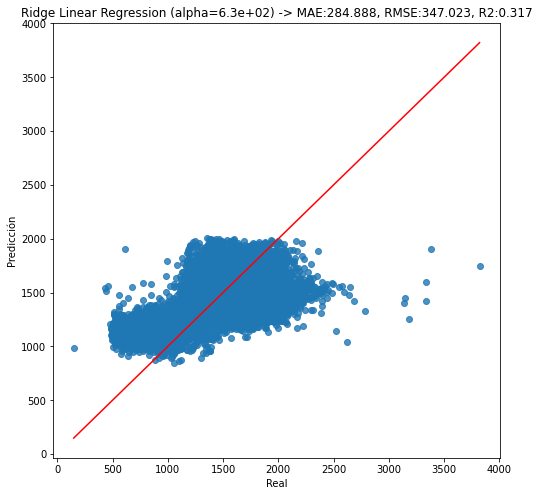

In [12]:
model = Ridge(alpha=6.3e+02)
mae_val, rmse_val, r2_val, mae_tst, rmse_tst, r2_tst, y_validacion, prediccion_validacion, y_test, prediccion_testeo = entrena_model(model)
dibuja_preds(y_test, prediccion_testeo, mae_tst, rmse_tst, r2_tst, 'Ridge Linear Regression (alpha=6.3e+02) -> ')

In [13]:
from sklearn.neighbors import KNeighborsRegressor
for n_neighbors in range(30):
    model = KNeighborsRegressor(n_neighbors=n_neighbors+1) 
    mae_val, rmse_val, r2_val, mae_tst, rmse_tst, r2_tst, _, _, _, _ = entrena_model(model)
    print('KNN con k={} vecinos -> \
    Val:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}] \
    Test:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}]'.format(n_neighbors+1, mae_val, rmse_val, r2_val, 
                                                      mae_tst, rmse_tst, r2_tst))

KNN con k=1 vecinos ->     Val:[MAE=212.410,RMSE=288.060,R2=0.503]     Test:[MAE=214.519,RMSE=292.564,R2=0.515]
KNN con k=2 vecinos ->     Val:[MAE=199.139,RMSE=265.790,R2=0.577]     Test:[MAE=203.461,RMSE=273.137,R2=0.577]
KNN con k=3 vecinos ->     Val:[MAE=192.958,RMSE=255.423,R2=0.609]     Test:[MAE=194.491,RMSE=259.106,R2=0.619]
KNN con k=4 vecinos ->     Val:[MAE=190.063,RMSE=249.734,R2=0.626]     Test:[MAE=190.034,RMSE=252.561,R2=0.638]
KNN con k=5 vecinos ->     Val:[MAE=188.123,RMSE=245.910,R2=0.638]     Test:[MAE=187.166,RMSE=247.917,R2=0.651]
KNN con k=6 vecinos ->     Val:[MAE=187.504,RMSE=243.737,R2=0.644]     Test:[MAE=185.606,RMSE=245.091,R2=0.659]
KNN con k=7 vecinos ->     Val:[MAE=185.994,RMSE=241.327,R2=0.651]     Test:[MAE=184.856,RMSE=242.938,R2=0.665]
KNN con k=8 vecinos ->     Val:[MAE=184.748,RMSE=239.308,R2=0.657]     Test:[MAE=183.821,RMSE=241.137,R2=0.670]
KNN con k=9 vecinos ->     Val:[MAE=183.840,RMSE=238.041,R2=0.661]     Test:[MAE=183.543,RMSE=240.041,R2

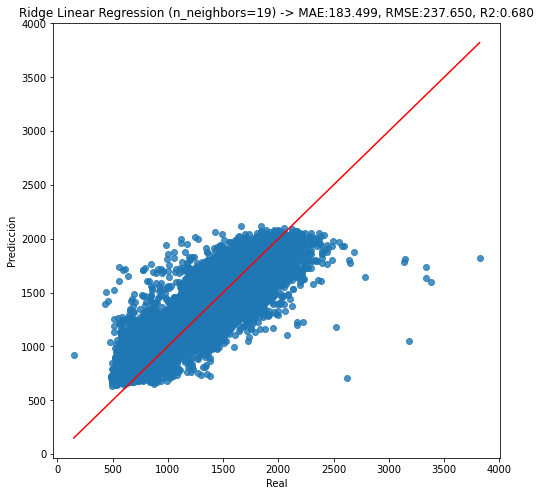

In [14]:
model = KNeighborsRegressor(n_neighbors=19) 
mae_val, rmse_val, r2_val, mae_tst, rmse_tst, r2_tst, y_validacion, prediccion_validacion, y_test, prediccion_testeo = entrena_model(model)
dibuja_preds(y_test, prediccion_testeo, mae_tst, rmse_tst, r2_tst, 'Ridge Linear Regression (n_neighbors=19) -> ')

In [15]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.neural_network import MLPRegressor
for num_neuronas in np.arange(1,51,5):
    model = MLPRegressor(hidden_layer_sizes=(num_neuronas,), solver='lbfgs')
    mae_val, rmse_val, r2_val, mae_tst, rmse_tst, r2_tst, _, _, _, _ = entrena_model(model)
    print('ANN con num_neuronas={} -> \
    Val:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}] \
    Test:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}]'.format(num_neuronas,
                                                      mae_val, rmse_val, r2_val, 
                                                      mae_tst, rmse_tst, r2_tst))

ANN con num_neuronas=1 ->     Val:[MAE=275.656,RMSE=337.105,R2=0.319]     Test:[MAE=285.940,RMSE=347.280,R2=0.316]
ANN con num_neuronas=6 ->     Val:[MAE=180.461,RMSE=230.694,R2=0.681]     Test:[MAE=175.012,RMSE=227.609,R2=0.706]
ANN con num_neuronas=11 ->     Val:[MAE=274.524,RMSE=336.932,R2=0.320]     Test:[MAE=283.515,RMSE=345.321,R2=0.324]
ANN con num_neuronas=16 ->     Val:[MAE=274.173,RMSE=336.695,R2=0.321]     Test:[MAE=283.473,RMSE=345.088,R2=0.325]
ANN con num_neuronas=21 ->     Val:[MAE=180.469,RMSE=231.750,R2=0.678]     Test:[MAE=174.097,RMSE=227.972,R2=0.705]
ANN con num_neuronas=26 ->     Val:[MAE=178.008,RMSE=230.312,R2=0.682]     Test:[MAE=172.566,RMSE=227.858,R2=0.706]
ANN con num_neuronas=31 ->     Val:[MAE=178.815,RMSE=229.377,R2=0.685]     Test:[MAE=172.440,RMSE=225.614,R2=0.711]
ANN con num_neuronas=36 ->     Val:[MAE=173.711,RMSE=224.497,R2=0.698]     Test:[MAE=170.551,RMSE=224.390,R2=0.715]
ANN con num_neuronas=41 ->     Val:[MAE=178.454,RMSE=229.367,R2=0.685]    

In [16]:
from sklearn.neural_network import MLPRegressor
for num_neuronas in np.arange(1,51,5):
    model = MLPRegressor(hidden_layer_sizes=(num_neuronas,), solver='lbfgs', activation='logistic')
    mae_val, rmse_val, r2_val, mae_tst, rmse_tst, r2_tst, _, _, _, _ = entrena_model(model)
    print('ANN con num_neuronas={} -> \
    Val:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}] \
    Test:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}]'.format(num_neuronas,
                                                      mae_val, rmse_val, r2_val, 
                                                      mae_tst, rmse_tst, r2_tst))

ANN con num_neuronas=1 ->     Val:[MAE=233.561,RMSE=290.037,R2=0.496]     Test:[MAE=235.798,RMSE=294.880,R2=0.507]
ANN con num_neuronas=6 ->     Val:[MAE=229.022,RMSE=284.592,R2=0.515]     Test:[MAE=230.977,RMSE=289.224,R2=0.526]
ANN con num_neuronas=11 ->     Val:[MAE=182.451,RMSE=235.639,R2=0.667]     Test:[MAE=180.534,RMSE=237.799,R2=0.679]
ANN con num_neuronas=16 ->     Val:[MAE=195.228,RMSE=247.553,R2=0.633]     Test:[MAE=194.684,RMSE=250.534,R2=0.644]
ANN con num_neuronas=21 ->     Val:[MAE=181.711,RMSE=233.015,R2=0.675]     Test:[MAE=174.584,RMSE=228.686,R2=0.703]
ANN con num_neuronas=26 ->     Val:[MAE=176.391,RMSE=227.847,R2=0.689]     Test:[MAE=171.322,RMSE=225.096,R2=0.713]
ANN con num_neuronas=31 ->     Val:[MAE=175.232,RMSE=226.350,R2=0.693]     Test:[MAE=169.975,RMSE=223.972,R2=0.716]
ANN con num_neuronas=36 ->     Val:[MAE=174.289,RMSE=224.527,R2=0.698]     Test:[MAE=170.087,RMSE=222.944,R2=0.718]
ANN con num_neuronas=41 ->     Val:[MAE=173.803,RMSE=225.367,R2=0.696]    

In [17]:
for num_neuronas in np.arange(16,47,1):
    model = MLPRegressor(hidden_layer_sizes=(num_neuronas,), solver='lbfgs', activation='logistic')
    mae_val, rmse_val, r2_val, mae_tst, rmse_tst, r2_tst, _, _, _, _ = entrena_model(model)
    print('ANN con num_neuronas={} -> \
    Val:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}] \
    Test:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}]'.format(num_neuronas,
                                                      mae_val, rmse_val, r2_val, 
                                                      mae_tst, rmse_tst, r2_tst))

ANN con num_neuronas=16 ->     Val:[MAE=187.771,RMSE=239.372,R2=0.657]     Test:[MAE=186.476,RMSE=240.214,R2=0.673]
ANN con num_neuronas=17 ->     Val:[MAE=177.092,RMSE=228.377,R2=0.688]     Test:[MAE=175.035,RMSE=229.071,R2=0.702]
ANN con num_neuronas=18 ->     Val:[MAE=182.074,RMSE=233.347,R2=0.674]     Test:[MAE=176.787,RMSE=230.511,R2=0.699]
ANN con num_neuronas=19 ->     Val:[MAE=188.763,RMSE=240.177,R2=0.654]     Test:[MAE=182.734,RMSE=235.558,R2=0.685]
ANN con num_neuronas=20 ->     Val:[MAE=176.713,RMSE=227.576,R2=0.690]     Test:[MAE=170.084,RMSE=223.829,R2=0.716]
ANN con num_neuronas=21 ->     Val:[MAE=177.042,RMSE=229.073,R2=0.686]     Test:[MAE=172.528,RMSE=226.128,R2=0.710]
ANN con num_neuronas=22 ->     Val:[MAE=179.651,RMSE=232.215,R2=0.677]     Test:[MAE=174.216,RMSE=229.656,R2=0.701]
ANN con num_neuronas=23 ->     Val:[MAE=183.077,RMSE=233.548,R2=0.673]     Test:[MAE=179.693,RMSE=232.761,R2=0.693]
ANN con num_neuronas=24 ->     Val:[MAE=173.426,RMSE=224.044,R2=0.699]  

In [18]:
for num_neuronas in [39]:
    for alpha in np.power(10.0,np.arange(-7,3,1)):
        model = MLPRegressor(hidden_layer_sizes=(num_neuronas,), alpha=alpha, solver='lbfgs', activation='logistic')
        mae_val, rmse_val, r2_val, mae_tst, rmse_tst, r2_tst, _, _, _, _ = entrena_model(model)
        print('ANN neuronas={} alpha={:,.1e} -> \
        Val:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}] \
        Test:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}]'.format(num_neuronas, alpha,
                                                          mae_val, rmse_val, r2_val, 
                                                          mae_tst, rmse_tst, r2_tst))

ANN neuronas=39 alpha=1.0e-07 ->         Val:[MAE=173.482,RMSE=222.904,R2=0.702]         Test:[MAE=164.864,RMSE=217.427,R2=0.732]
ANN neuronas=39 alpha=1.0e-06 ->         Val:[MAE=174.483,RMSE=224.532,R2=0.698]         Test:[MAE=168.643,RMSE=221.938,R2=0.721]
ANN neuronas=39 alpha=1.0e-05 ->         Val:[MAE=175.079,RMSE=225.174,R2=0.696]         Test:[MAE=170.351,RMSE=223.672,R2=0.716]
ANN neuronas=39 alpha=1.0e-04 ->         Val:[MAE=171.428,RMSE=221.012,R2=0.707]         Test:[MAE=164.751,RMSE=217.450,R2=0.732]
ANN neuronas=39 alpha=1.0e-03 ->         Val:[MAE=173.987,RMSE=224.574,R2=0.698]         Test:[MAE=167.446,RMSE=220.221,R2=0.725]
ANN neuronas=39 alpha=1.0e-02 ->         Val:[MAE=174.228,RMSE=224.202,R2=0.699]         Test:[MAE=167.033,RMSE=220.655,R2=0.724]
ANN neuronas=39 alpha=1.0e-01 ->         Val:[MAE=174.970,RMSE=225.624,R2=0.695]         Test:[MAE=169.372,RMSE=222.993,R2=0.718]
ANN neuronas=39 alpha=1.0e+00 ->         Val:[MAE=173.752,RMSE=224.096,R2=0.699]         T

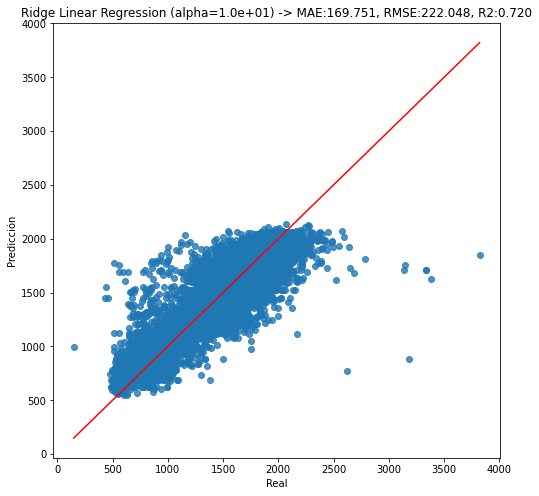

In [19]:
model = MLPRegressor(hidden_layer_sizes=(39,), alpha=1.0e+01, solver='lbfgs', activation='logistic')
mae_val, rmse_val, r2_val, mae_tst, rmse_tst, r2_tst, y_validacion, prediccion_validacion, y_test, prediccion_testeo = entrena_model(model)
dibuja_preds(y_test, prediccion_testeo, mae_tst, rmse_tst, r2_tst, 'Ridge Linear Regression (alpha=1.0e+01) -> ')

In [20]:
from sklearn.svm import SVR
for num_neuronas in [0.0001,0.001,0.01,0.1,1]:
    model = SVR(kernel='rbf', gamma=num_neuronas)
    mae_val, rmse_val, r2_val, mae_tst, rmse_tst, r2_tst, _, _, _, _ = entrena_model(model)
    print('ANN con num_neuronas={} -> \
    Val:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}] \
    Test:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}]'.format(num_neuronas, mae_val, rmse_val, r2_val, 
                                                      mae_tst, rmse_tst, r2_tst))

ANN con num_neuronas=0.0001 ->     Val:[MAE=323.131,RMSE=413.556,R2=-0.025]     Test:[MAE=333.359,RMSE=429.363,R2=-0.045]
ANN con num_neuronas=0.001 ->     Val:[MAE=319.517,RMSE=408.656,R2=-0.001]     Test:[MAE=329.851,RMSE=424.346,R2=-0.021]
ANN con num_neuronas=0.01 ->     Val:[MAE=296.606,RMSE=373.786,R2=0.163]     Test:[MAE=306.522,RMSE=387.510,R2=0.149]
ANN con num_neuronas=0.1 ->     Val:[MAE=261.956,RMSE=328.417,R2=0.354]     Test:[MAE=272.305,RMSE=340.286,R2=0.343]
ANN con num_neuronas=1 ->     Val:[MAE=268.523,RMSE=343.734,R2=0.292]     Test:[MAE=278.881,RMSE=357.965,R2=0.273]


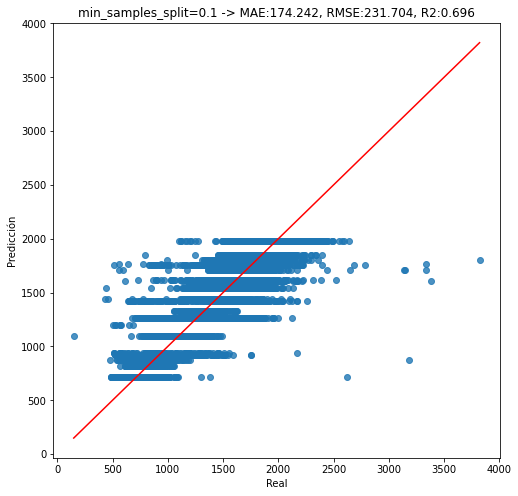

In [21]:
model = DecisionTreeRegressor(min_samples_split=0.1)
mae_val, rmse_val, r2_val, mae_tst, rmse_tst, r2_tst, y_validacion, prediccion_validacion, y_test, prediccion_testeo = entrena_model(model)
dibuja_preds(y_test, prediccion_testeo, mae_tst, rmse_tst, r2_tst, 'min_samples_split=0.1 -> ')

In [22]:
from sklearn.tree import DecisionTreeRegressor
for num_neuronas in range(2,1000,10):
    model = DecisionTreeRegressor(min_samples_split=num_neuronas)
    mae_val, rmse_val, r2_val, mae_tst, rmse_tst, r2_tst, _, _, _, _ = entrena_model(model)
    print('ANN con num_neuronas={} -> \
    Val:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}] \
    Test:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}]'.format(num_neuronas, mae_val, rmse_val, r2_val, 
                                                      mae_tst, rmse_tst, r2_tst))

ANN con num_neuronas=2 ->     Val:[MAE=211.147,RMSE=285.675,R2=0.511]     Test:[MAE=210.139,RMSE=286.593,R2=0.534]
ANN con num_neuronas=12 ->     Val:[MAE=192.301,RMSE=256.835,R2=0.605]     Test:[MAE=191.782,RMSE=256.699,R2=0.626]
ANN con num_neuronas=22 ->     Val:[MAE=185.207,RMSE=245.892,R2=0.638]     Test:[MAE=183.072,RMSE=243.505,R2=0.664]
ANN con num_neuronas=32 ->     Val:[MAE=182.789,RMSE=241.342,R2=0.651]     Test:[MAE=178.917,RMSE=238.883,R2=0.676]
ANN con num_neuronas=42 ->     Val:[MAE=180.386,RMSE=237.764,R2=0.661]     Test:[MAE=176.519,RMSE=235.066,R2=0.687]
ANN con num_neuronas=52 ->     Val:[MAE=178.573,RMSE=235.815,R2=0.667]     Test:[MAE=174.325,RMSE=232.323,R2=0.694]
ANN con num_neuronas=62 ->     Val:[MAE=177.211,RMSE=233.634,R2=0.673]     Test:[MAE=172.695,RMSE=230.722,R2=0.698]
ANN con num_neuronas=72 ->     Val:[MAE=177.269,RMSE=233.406,R2=0.674]     Test:[MAE=172.778,RMSE=230.649,R2=0.698]
ANN con num_neuronas=82 ->     Val:[MAE=175.188,RMSE=230.292,R2=0.682]   

In [23]:
from sklearn.tree import DecisionTreeRegressor
for num_neuronas in range(150,170,1):
    model = DecisionTreeRegressor(min_samples_split=num_neuronas)
    mae_val, rmse_val, r2_val, mae_tst, rmse_tst, r2_tst, _, _, _, _ = entrena_model(model)
    print('ANN con num_neuronas={} -> \
    Val:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}] \
    Test:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}]'.format(num_neuronas, mae_val, rmse_val, r2_val, 
                                                      mae_tst, rmse_tst, r2_tst))

ANN con num_neuronas=150 ->     Val:[MAE=172.769,RMSE=226.467,R2=0.693]     Test:[MAE=166.183,RMSE=222.247,R2=0.720]
ANN con num_neuronas=151 ->     Val:[MAE=172.359,RMSE=226.087,R2=0.694]     Test:[MAE=166.102,RMSE=222.172,R2=0.720]
ANN con num_neuronas=152 ->     Val:[MAE=172.214,RMSE=225.931,R2=0.694]     Test:[MAE=165.970,RMSE=221.928,R2=0.721]
ANN con num_neuronas=153 ->     Val:[MAE=172.241,RMSE=225.955,R2=0.694]     Test:[MAE=165.989,RMSE=221.942,R2=0.721]
ANN con num_neuronas=154 ->     Val:[MAE=172.241,RMSE=225.955,R2=0.694]     Test:[MAE=165.989,RMSE=221.942,R2=0.721]
ANN con num_neuronas=155 ->     Val:[MAE=172.241,RMSE=225.955,R2=0.694]     Test:[MAE=165.989,RMSE=221.942,R2=0.721]
ANN con num_neuronas=156 ->     Val:[MAE=171.946,RMSE=225.273,R2=0.696]     Test:[MAE=165.676,RMSE=221.441,R2=0.722]
ANN con num_neuronas=157 ->     Val:[MAE=171.646,RMSE=224.956,R2=0.697]     Test:[MAE=165.362,RMSE=221.144,R2=0.723]
ANN con num_neuronas=158 ->     Val:[MAE=171.646,RMSE=224.956,R2

In [24]:
for num_neuronas in range(2,1000,10):
    model = DecisionTreeRegressor(min_samples_split=num_neuronas,splitter="random",criterion="friedman_mse")
    mae_val, rmse_val, r2_val, mae_tst, rmse_tst, r2_tst, _, _, _, _ = entrena_model(model)
    print('ANN con num_neuronas={} -> \
    Val:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}] \
    Test:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}]'.format(num_neuronas, mae_val, rmse_val, r2_val, 
                                                      mae_tst, rmse_tst, r2_tst))

ANN con num_neuronas=2 ->     Val:[MAE=205.697,RMSE=277.175,R2=0.540]     Test:[MAE=205.962,RMSE=278.951,R2=0.559]
ANN con num_neuronas=12 ->     Val:[MAE=180.446,RMSE=237.231,R2=0.663]     Test:[MAE=177.018,RMSE=236.481,R2=0.683]
ANN con num_neuronas=22 ->     Val:[MAE=173.684,RMSE=225.756,R2=0.695]     Test:[MAE=170.877,RMSE=226.924,R2=0.708]
ANN con num_neuronas=32 ->     Val:[MAE=173.207,RMSE=226.539,R2=0.693]     Test:[MAE=168.682,RMSE=223.176,R2=0.718]
ANN con num_neuronas=42 ->     Val:[MAE=172.893,RMSE=227.327,R2=0.690]     Test:[MAE=167.703,RMSE=224.708,R2=0.714]
ANN con num_neuronas=52 ->     Val:[MAE=171.406,RMSE=223.997,R2=0.699]     Test:[MAE=165.333,RMSE=220.293,R2=0.725]
ANN con num_neuronas=62 ->     Val:[MAE=172.973,RMSE=226.001,R2=0.694]     Test:[MAE=165.795,RMSE=222.217,R2=0.720]
ANN con num_neuronas=72 ->     Val:[MAE=171.433,RMSE=224.847,R2=0.697]     Test:[MAE=167.787,RMSE=223.439,R2=0.717]
ANN con num_neuronas=82 ->     Val:[MAE=170.817,RMSE=222.468,R2=0.703]   

In [25]:
for num_neuronas in range(100,120,1):
    model = DecisionTreeRegressor(min_samples_split=num_neuronas,splitter="random",criterion="friedman_mse")
    mae_val, rmse_val, r2_val, mae_tst, rmse_tst, r2_tst, _, _, _, _ = entrena_model(model)
    print('ANN con num_neuronas={} -> \
    Val:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}] \
    Test:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}]'.format(num_neuronas, mae_val, rmse_val, r2_val, 
                                                      mae_tst, rmse_tst, r2_tst))

ANN con num_neuronas=100 ->     Val:[MAE=172.180,RMSE=227.388,R2=0.690]     Test:[MAE=168.932,RMSE=226.944,R2=0.708]
ANN con num_neuronas=101 ->     Val:[MAE=175.535,RMSE=228.775,R2=0.686]     Test:[MAE=171.172,RMSE=226.320,R2=0.710]
ANN con num_neuronas=102 ->     Val:[MAE=173.834,RMSE=227.348,R2=0.690]     Test:[MAE=170.724,RMSE=227.770,R2=0.706]
ANN con num_neuronas=103 ->     Val:[MAE=169.529,RMSE=221.900,R2=0.705]     Test:[MAE=165.502,RMSE=219.009,R2=0.728]
ANN con num_neuronas=104 ->     Val:[MAE=171.669,RMSE=223.304,R2=0.701]     Test:[MAE=167.425,RMSE=221.954,R2=0.721]
ANN con num_neuronas=105 ->     Val:[MAE=173.989,RMSE=227.234,R2=0.691]     Test:[MAE=169.293,RMSE=224.842,R2=0.713]
ANN con num_neuronas=106 ->     Val:[MAE=171.504,RMSE=224.218,R2=0.699]     Test:[MAE=169.084,RMSE=224.621,R2=0.714]
ANN con num_neuronas=107 ->     Val:[MAE=172.841,RMSE=225.044,R2=0.697]     Test:[MAE=168.577,RMSE=224.122,R2=0.715]
ANN con num_neuronas=108 ->     Val:[MAE=171.580,RMSE=224.890,R2

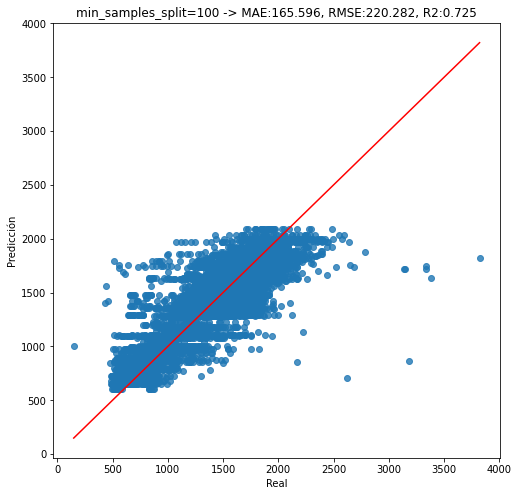

In [26]:
model = DecisionTreeRegressor(min_samples_split=100,splitter="random",criterion="friedman_mse")
mae_val, rmse_val, r2_val, mae_tst, rmse_tst, r2_tst, y_validacion, prediccion_validacion, y_test, prediccion_testeo = entrena_model(model)
dibuja_preds(y_test, prediccion_testeo, mae_tst, rmse_tst, r2_tst, 'min_samples_split=100 -> ')

In [27]:
from sklearn.tree import ExtraTreeRegressor
for num_neuronas in np.arange(0.001,1,0.003):
    model = ExtraTreeRegressor(min_samples_split=num_neuronas)
    mae_val, rmse_val, r2_val, mae_tst, rmse_tst, r2_tst, _, _, _, _ = entrena_model(model)
    print('ANN con num_neuronas={} -> \
    Val:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}] \
    Test:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}]'.format(num_neuronas, mae_val, rmse_val, r2_val, 
                                                      mae_tst, rmse_tst, r2_tst))

ANN con num_neuronas=0.001 ->     Val:[MAE=184.078,RMSE=244.095,R2=0.643]     Test:[MAE=182.396,RMSE=244.638,R2=0.661]
ANN con num_neuronas=0.004 ->     Val:[MAE=172.399,RMSE=225.326,R2=0.696]     Test:[MAE=170.796,RMSE=227.073,R2=0.708]
ANN con num_neuronas=0.007 ->     Val:[MAE=169.343,RMSE=222.297,R2=0.704]     Test:[MAE=165.571,RMSE=220.461,R2=0.724]
ANN con num_neuronas=0.010000000000000002 ->     Val:[MAE=180.600,RMSE=235.763,R2=0.667]     Test:[MAE=176.450,RMSE=234.278,R2=0.689]
ANN con num_neuronas=0.013000000000000001 ->     Val:[MAE=172.732,RMSE=225.641,R2=0.695]     Test:[MAE=168.579,RMSE=223.788,R2=0.716]
ANN con num_neuronas=0.016 ->     Val:[MAE=173.943,RMSE=226.446,R2=0.693]     Test:[MAE=168.962,RMSE=223.757,R2=0.716]
ANN con num_neuronas=0.019000000000000003 ->     Val:[MAE=171.055,RMSE=222.005,R2=0.705]     Test:[MAE=167.135,RMSE=221.732,R2=0.721]
ANN con num_neuronas=0.022000000000000002 ->     Val:[MAE=174.427,RMSE=227.739,R2=0.689]     Test:[MAE=167.767,RMSE=222.09

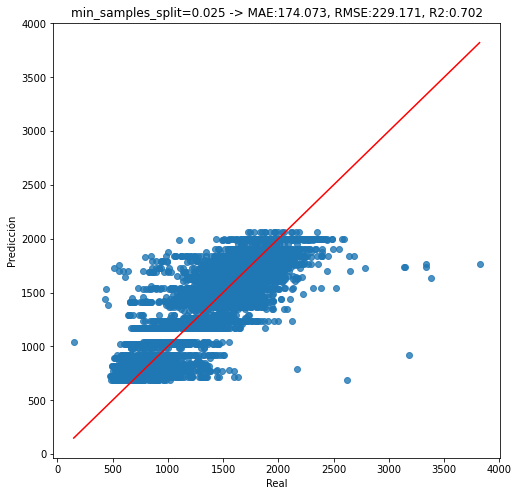

In [28]:
model = ExtraTreeRegressor(min_samples_split=0.025)
mae_val, rmse_val, r2_val, mae_tst, rmse_tst, r2_tst, y_validacion, prediccion_validacion, y_test, prediccion_testeo = entrena_model(model)
dibuja_preds(y_test, prediccion_testeo, mae_tst, rmse_tst, r2_tst, 'min_samples_split=0.025 -> ')

Tabla:

Lineal de Ridge Regression --> RIDGE con alpha=6.3e+02 ->    Val:[MAE=274.633,RMSE=336.561,R2=0.321]     Test:[MAE=284.887,RMSE=347.023,R2=0.317]

K-NN --> KNN con k=19 vecinos ->     Val:[MAE=183.167,RMSE=235.136,R2=0.669]     Test:[MAE=183.499,RMSE=237.650,R2=0.680]

SVR --> ANN con num_neuronas=0.1 ->     Val:[MAE=261.956,RMSE=328.417,R2=0.354]     Test:[MAE=272.305,RMSE=340.286,R2=0.343]

MLPRegressor --> ANN neuronas=39 alpha=1.0e+01 ->         Val:[MAE=170.719,RMSE=220.460,R2=0.709]         Test:[MAE=166.299,RMSE=218.831,R2=0.728]

ExtraTreeRegressor --> ANN con num_neuronas=0.025 ->     Val:[MAE=169.406,RMSE=221.025,R2=0.707]     Test:[MAE=166.065,RMSE=219.768,R2=0.726]

DecisionTreeRegressor --> ANN con num_neuronas=100 ->     Val:[MAE=170.360,RMSE=220.885,R2=0.708]     Test:[MAE=165.991,RMSE=220.322,R2=0.725]

Con el que mejor resultados he obtenido ha sido MLPRegressor

# 2. Uso de los Modelos para la Toma de Decisiones ante un Vertido de Gasóleo en el Iregua

El 1 de Julio de 2010, nos avisan que un camión cisterna ha sufrido un accidente a las 14:00 y ha derramado gasóleo en el río Iregua a la altura de Panzares. 

![](https://e00-elmundo.uecdn.es/elmundo/imagenes/2010/06/16/1276675934_0.jpg)

Se dispone de tres horas, aproximadamente, para tomar una decisión antes de que el agua contaminada llegue a la zona de captación de aguas de la ETAP. Finalmente, **se decide cerrar la entrada de agua a las 16:00 y mantenerla cerrada hasta las 8:00 de la mañana del día siguiente, o sea de 16:00 a 7:59 (16 horas cerrada), que es cuando entra el nuevo turno de trabajo, de modo que se abrirá la esclusa a las 8.00 de la mañana**. De este modo, se espera que exista suficiente tiempo para retirar el camión accidentado y que la parte más voluminosa del vertido sobrepase la entrada a la ETAP. 

Los gestores de la ETAP y responsables de Medio Ambiente y Aguas, están preocupados por saber si el agua almacenada en la ETAP va a ser suficiente para suministrar a Logroño y pueblos adyacentes en esas horas en que la entrada está cerrada. Para ello, **se nos solicita que estimemos el consumo total de agua durante esas horas considerando que la temperatura ambiental prevista es la que aparece en la base de datos “etap_testeo2010.arff”**.

Presente una tabla y unos gráficos con el consumo por horas y el consumo acumulado.

Suponiendo que disponemos de 35000 metros cúbicos, ¿Cuál es la diferencia entre el consumo y el agua almacenada que disponemos? ¿Es posible cerrar esas horas sin que la ciudad quede desabastecida? 

Justifique los resultados frente a los responsables de Medio Ambiente de la Ciudad

# ENTREGA

Recuerda guardar tus cambios en tu repositorio utilizando la opción "Save a copy in GitHub..." del menú File.